In [2]:
import numpy as np
import matplotlib.pyplot as plt

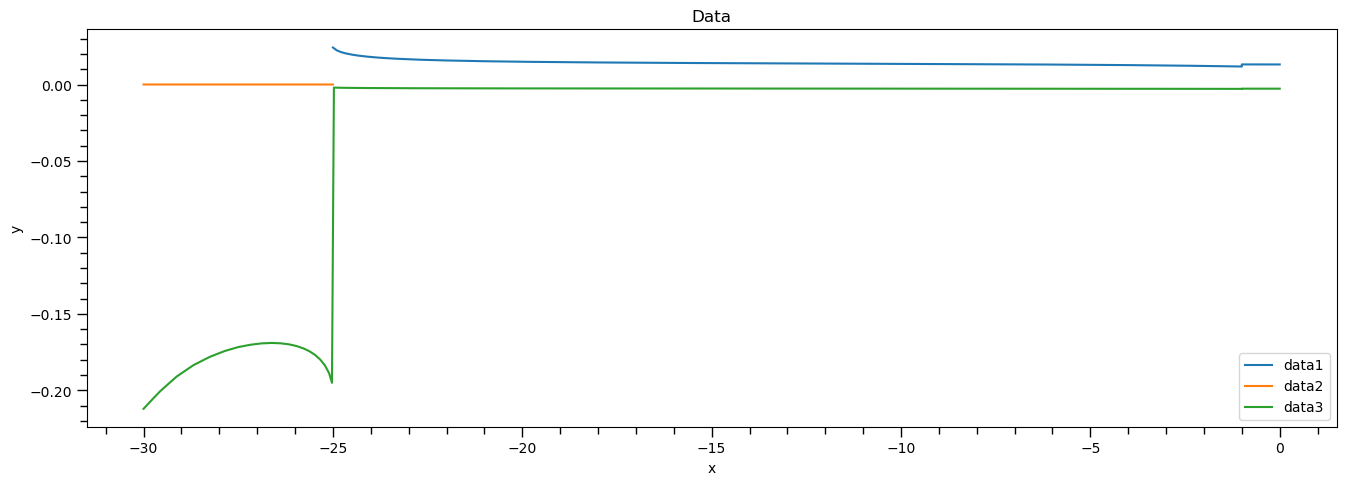

In [25]:
data1 = np.loadtxt('Untitled.txt')
data2 = np.loadtxt('Untitled1.txt')
data3 = np.loadtxt('Untitled2.txt')

plt.plot(data1[:,0], data1[:,1], label='data1')
plt.plot(data2[:,0], data2[:,1], label='data2')
plt.plot(data3[:,0], data3[:,1], label='data3')
plt.legend()

#add minor tick marks etc
plt.minorticks_on()
#make the tickmarks longer
plt.tick_params(axis='both', direction='out', length=7, width=1)
#make the minor ticks shorter
plt.tick_params(axis='both', which='minor', direction='out', length=5, width=1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')

plt.tight_layout()
#Make it long and thin
plt.gcf().set_size_inches(15, 5)


plt.show()

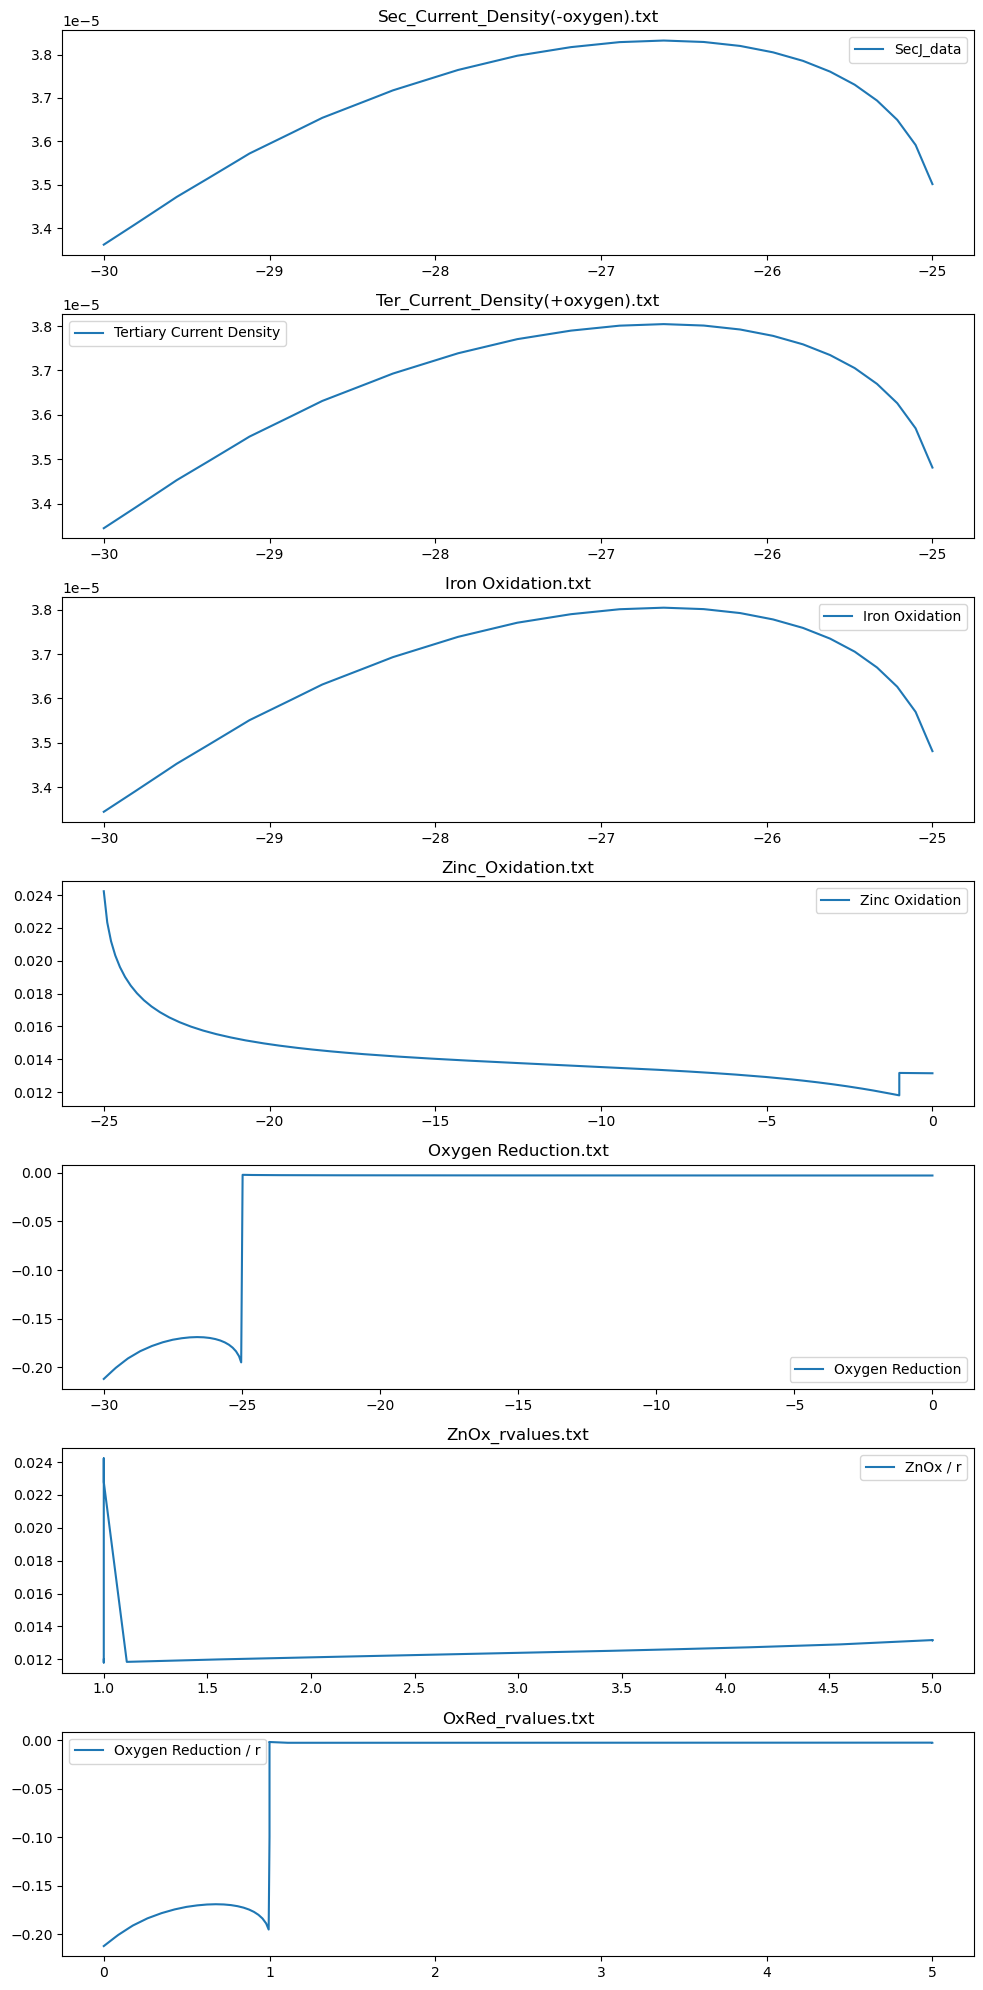

In [2]:
# File paths and labels
file_paths = [
    ("Sec_Current_Density(-oxygen).txt", "SecJ_data"),
    ("Ter_Current_Density(+oxygen).txt", "Tertiary Current Density"),
    ("Iron Oxidation.txt", "Iron Oxidation"),
    ("Zinc_Oxidation.txt", "Zinc Oxidation"),
    ("Oxygen Reduction.txt", "Oxygen Reduction"),
    ("ZnOx_rvalues.txt", "ZnOx / r"),
    ("OxRed_rvalues.txt", "Oxygen Reduction / r")]

# Load data
data = [np.loadtxt(file_path) for file_path, _ in file_paths]

# Plot data on seperate axes
fig, axs = plt.subplots(len(data), 1, figsize=(10, 20))
for ax, (d, (file_path, label)) in zip(axs, zip(data, file_paths)):
    ax.plot(d[:, 0], d[:, 1], label=label)
    ax.set_title(file_path)
    ax.legend()

plt.tight_layout()
plt.show()

In [84]:
SecJ_x_values = data[0][:, 0]
SecJ_y_values = data[0][:, 1]
TerJ_x_values = data[1][:, 0]
TerJ_y_values = data[1][:, 1]
FeOx_x_values = data[2][:, 0]
FeOx_y_values = data[2][:, 1]
ZnOx_x_values = data[3][:, 0]
ZnOx_y_values = data[3][:, 1]
ORed_x_values = data[4][:, 0]
ORed_y_values = data[4][:, 1]
ZnOx_rvalues_x_values = data[5][:, 0]
ZnOx_rvalues_y_values = data[5][:, 1]
ORed_rvalues_x_values = data[6][:, 0]
ORed_rvalues_y_values = data[6][:, 1]

In [85]:
## Function to compute the total surface current for the cylinder section
def compute_total_current_cylinder(S, T, z, j):
    """
    Compute the total current for a cylinder section.

    Parameters
    ----------
    S : float
        Cylinder surface area.
    T : float
        Cylinder thickness.
    z : array_like
        Array of z values.
    j : array_like
        Array of current density values.

    Returns
    -------
    float
        Total current for the cylinder section.
    """
    

    N = len(z) - 1
    Acylinder = 2 * np.pi * S * T
    w = np.zeros(N + 1)
    
    # Compute weights
    w[0] = 1 / (2 * T) * (z[1] - z[0])
    w[N] = 1 / (2 * T) * (z[N] - z[N - 1])
    for i in range(1, N):
        w[i] = 1 / (2 * T) * (z[i + 1] - z[i - 1])
    
    j_avg = np.sum(w * j) # Average current density
    Icylinder = Acylinder * j_avg # Total current
    
    return Icylinder

Ox_Icylinder = compute_total_current_cylinder(1, 24, ZnOx_x_values, ZnOx_y_values)
mask = (ORed_x_values >= 1) & (ORed_x_values <= 24)

# Mask the ORed data
limited_x_values = ORed_x_values[mask]
limited_y_values = ORed_y_values[mask]

In [ ]:
# Function to calculate total surface current for cone section

def compute_total_current_cone(R, h, z, j):
    """
    Calculate the total current for the cone section using the given current densities.

    Parameters:
    R (float): Radius of the base of the cone.
    h (float): Slant height of the cone.
    z (array-like): Positions along the slant height where current density is measured.
    j (array-like): Current densities measured at corresponding z positions.

    Returns:
    float: The total current for the cone section
    """

    N = len(z) - 1  # Number of intervals
    A_cone = np.pi * R * np.sqrt(h**2 + R**2)
    w = np.zeros(N + 1)

    f = (z - z[0]) / h

    # Compute weights
    w[0] = 0  # Weight for the first point
    w[N] = 1 - f[N-1]  # Weight for the last point
    for i in range(1, N):
        w[i] = f[i] * (f[i+1] - f[i-1])

    # Compute average current density
    j_avg = np.sum(w * j)

    # Compute total current
    I_cone = A_cone * j_avg
    
    return I_cone

# Example usage
R = 1  # radius of the base of the cone
h = 5  # slant height of the cone
z = FeOx_x_values  # positions
j = FeOx_y_values  # current densities at positions

I_cone = compute_total_current_cone(R, h, z, j)

In [87]:
###
### Compute the total current for the underside of the nail head
###

# Create a mask to filter x values between x_min and x_max
mask1 = (ORed_x_values >= -1) & (ORed_x_values <= 0)
mask2 = (ZnOx_x_values >= -1) & (ZnOx_x_values <= 0)
mask3 = (ORed_rvalues_x_values >= 1) & (ORed_rvalues_x_values <= 5)
mask4 = (ZnOx_rvalues_x_values >= 1) & (ZnOx_rvalues_x_values <= 5)

# Apply the mask to get the filtered x and y values
filtered_ORed_x_values = ORed_x_values[mask1]
filtered_ORed_y_values = ORed_y_values[mask1]

filtered_ZnOx_x_values = ZnOx_x_values[mask2]
filtered_ZnOx_y_values = ZnOx_y_values[mask2]

filtered_ORed_rvalues_x_values = ORed_rvalues_x_values[mask3]
filtered_ORed_rvalues_y_values = ORed_rvalues_y_values[mask3]

filtered_ZnOx_rvalues_x_values = ZnOx_rvalues_x_values[mask4]
filtered_ZnOx_rvalues_y_values = ZnOx_rvalues_y_values[mask4]

a = compute_total_current_cylinder(5, 1, filtered_ORed_x_values, filtered_ORed_y_values)
b = compute_total_current_cylinder(5, 1, filtered_ZnOx_x_values, filtered_ZnOx_y_values)
c = compute_total_current_head_under(1, 5, filtered_ORed_rvalues_x_values, filtered_ORed_rvalues_y_values)
d = compute_total_current_head_under(1, 5, filtered_ZnOx_rvalues_x_values, filtered_ZnOx_rvalues_y_values)

total_current_head = a + b + c + d

In [88]:
def compute_total_current_head_under(R, W, r, j):
    """
    Calculate the total current for the head under the nail using the given current densities.

    Parameters:
    R (float): Radius of the head of the nail.
    W (float): Radius of the head of the nail.
    r (array-like): Positions along the radius where current density is measured.
    j (array-like): Current densities measured at corresponding r positions.

    Returns:
    float: The total current for the head under the nail
    """
    N = len(r) - 1  # Number of intervals
    A_head_under = np.pi * (W**2 - R**2)
    w = np.zeros(N + 1)

    # Calculate a and b
    a = R / (W + R)
    b = (W - R) / (W + R)
    g = (r - R) / (W - R)

    # Compute weights
    w[0] = (a + b * g[0]) * (g[1] - g[0])  # For the first point
    w[N] = (a + b * g[N]) * (g[N] - g[N-1])  # For the last point
    for i in range(1, N):
        w[i] = (a + b * g[i]) * (g[i+1] - g[i-1])

    # Compute average current density
    j_avg = np.sum(w * j)

    # Compute total current
    I_head_under = A_head_under * j_avg
    
    return I_head_under

In [89]:
###
### Compute current in cylinder
###

mask5 = (ZnOx_x_values >= -25) & (ZnOx_x_values <= -1)
mask6 = (ORed_x_values >= -25) & (ORed_x_values <= -1)

filtered2_ZnOx_x_values = ZnOx_x_values[mask5]
filtered2_ZnOx_y_values = ZnOx_y_values[mask5]

filtered2_ORed_x_values = ORed_x_values[mask6]
filtered2_ORed_y_values = ORed_y_values[mask6]

e = compute_total_current_cylinder(1, 24, filtered2_ZnOx_x_values, filtered2_ZnOx_y_values)
f= compute_total_current_cylinder(1, 24, filtered2_ORed_x_values, filtered2_ORed_y_values)

total_current_cylinder = e + f

In [90]:
###
### Compute current in cone
###

mask7 = (ORed_x_values >= -30) & (ORed_x_values <= -25)
filtered_ORed_x_values = ORed_x_values[mask7]
filtered_ORed_y_values = ORed_y_values[mask7]

g = compute_total_current_cone(1, 5, filtered_ORed_x_values, filtered_ORed_y_values)
h = compute_total_current_cone(1, 5,  FeOx_x_values, FeOx_y_values)
total_current_cone = g + h


In [91]:
#print the values in a table rounded to 3 dp
print("Total Current in Cylinder: ", round(total_current_cylinder, 4))
print("Total Current in Head: ", round(total_current_head, 4))
print("Total Current in Cone: ", round(total_current_cone, 4))

Total Current in Cylinder:  1.7399
Total Current in Head:  1.0709
Total Current in Cone:  -2.8066
